# KEGG vs BEL gene sets comparison

### This notebook calculates the Jaccard index for gene sets in the KEGG PATHWAY database and gene sets in BEL graphs for each pathway in the KEGG PATHWAY database

In [17]:
import os
import itertools as itt
from collections import defaultdict
import seaborn as sns

from pybel import BELGraph, from_pickle

from pathme.constants import KEGG_BEL
from pathme.utils import get_files_in_folder

from bio2bel_kegg.manager import Manager

In [2]:
# Initiate KEGG Manager
kegg_manager = Manager()

### Get gene sets for each KEGG pathway in the KEGG PATHWAY database.

In [3]:
kegg_genes_set = kegg_manager.export_gene_sets()

### Get gene sets for each KEGG pathway BEL graph

In [4]:
# Get list of BEL graph pickles
pickles = get_files_in_folder(KEGG_BEL)

In [5]:
def get_genes_from_pickles(pickles):
    """Get BEL graph gene set for all KEGG pathways.

    :param list pickles: list of BEL graph pickles
    :return: BEL graph gene sets for each KEGG pathway 
    :rtype: dict[str,set]
    """
    pathway_genes_dict = {}
    
    for file_name in pickles:
        
        # Flattened graphs considered for gene sets 
        if file_name.endswith('_flatten.pickle'):
            graph = from_pickle(os.path.join(KEGG_BEL,file_name))
            
            # Get gene set for pathway 
            gene_set = get_genes_in_graph(graph) 
            file_name = file_name.strip('_flatten.pickle')
            file_name = 'path:' + file_name
            file_name = kegg_manager.get_pathway_by_id(file_name)

            pathway_genes_dict[str(file_name)] = gene_set
                
    return pathway_genes_dict


In [6]:
def get_genes_in_graph(graph):
    """Get BEL graph gene set for a KEGG pathway.

    :param pybel.BELGraph graph: BEL Graph
    :return: BEL graph gene set  
    :rtype: set
    """
    gene_set = set()
    
    for node, data in graph.nodes(data=True):
        if node.function in {'Protein', 'RNA'} and node.namespace == 'HGNC':
            gene_set.add(node.name)
            
    return gene_set

In [7]:
bel_genes_set = get_genes_from_pickles(pickles)

### For each pathway in the KEGG PATHWAY database, calculate the Jaccard index for gene sets from the database and from BEL graphs 

In [12]:
def jaccard_similarity(kegg_genes_set, bel_genes_set):
    """Get Jaccard similarity for gene sets in KEGG PATHWAYS database and BEL graphs.

    :param dict kegg_genes_set: gene sets for each pathway in KEGG PATHWAYS database
    :param dict bel_genes_set: gene sets for each BEL graph
    :return: similarity index 
    :rtype: int
    """    
    jaccard_similarities = []
    count = 0
    
    for (kegg_key, kegg_value), (bel_key, bel_value) in itt.product(kegg_genes_set.items(),bel_genes_set.items()):
        
        if kegg_key != bel_key:
            continue
            
        intersection = len(set.intersection(kegg_value, bel_value))
        union = len(kegg_value.union(bel_value))
        jaccard_index = intersection/union
        jaccard_similarities.append(jaccard_index)
        if jaccard_index == 1.0:
            count += 1
        else:
            print(f'Jaccard index = {jaccard_index:.3f} for {kegg_key}')
            
    print('The remaining {} gene sets in the KEGG PATHWAYS database and BEL graphs have a similarity of 100%.'.format(count))
    return jaccard_similarities

In [14]:
jaccard_similarities = jaccard_similarity(kegg_genes_set, bel_genes_set)

Jaccard index = 0.971 for Pentose and glucuronate interconversions - Homo sapiens (human)
Jaccard index = 0.963 for Ascorbate and aldarate metabolism - Homo sapiens (human)
Jaccard index = 0.966 for Steroid hormone biosynthesis - Homo sapiens (human)
Jaccard index = 0.983 for Purine metabolism - Homo sapiens (human)
Jaccard index = 0.980 for Pyrimidine metabolism - Homo sapiens (human)
Jaccard index = 0.960 for Arginine and proline metabolism - Homo sapiens (human)
Jaccard index = 0.944 for Starch and sucrose metabolism - Homo sapiens (human)
Jaccard index = 0.968 for Mucin type O-glycan biosynthesis - Homo sapiens (human)
Jaccard index = 0.990 for Glycerophospholipid metabolism - Homo sapiens (human)
Jaccard index = 0.979 for Ether lipid metabolism - Homo sapiens (human)
Jaccard index = 0.984 for Arachidonic acid metabolism - Homo sapiens (human)
Jaccard index = 0.966 for Linoleic acid metabolism - Homo sapiens (human)
Jaccard index = 0.960 for alpha-Linolenic acid metabolism - Homo s

#### Visualize Jaccard index distribution

/home/sarah/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


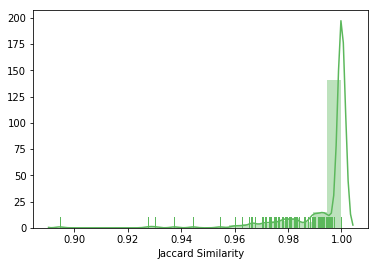

In [26]:
sns.distplot(jaccard_similarities, axlabel='Jaccard Similarity'', rug=True, bins=20, color='#5cb85c')
